## Importing the Libraries

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from arch import arch_model
import statsmodels.api as sm
from scipy.stats import ttest_1samp
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller, grangercausalitytests

## Data Preparation

### Regulation Data

In [7]:
reg_df = pd.read_csv("dataset/Regulations.csv", parse_dates=['Date']).drop('Target Sector', axis=1)
reg_df.head()

,Date,Event/Announcement,Organization
0,2016-05-04,Bank of England and Financial Services Act 201...,UK Government
1,2016-06-23,UK votes to leave the European Union (Brexit R...,UK Government
2,2016-08-15,"HM Treasury issues guidance on ""Regulatory Tre...",UK Government
3,2016-11-23,European Commission proposes amendments to the...,European Union
4,2017-03-29,UK triggers Article 50 to begin formal Brexit ...,UK Government


### Market Data

In [8]:
def convert_to_appropriate_datatypes(df):
    # Convert 'Date' column to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Remove commas from numeric columns and convert to float
    numeric_columns = ['Price', 'Open', 'High', 'Low']
    
    for col in numeric_columns:
        # Check if the column is of object (string) type before using .str methods
        if df[col].dtype == 'object':
            df[col] = df[col].str.replace(',', '').astype(float)
    
    # Handle 'Change %' column by stripping '%' and converting to float
    if df['Change %'].dtype == 'object':
        df['Change %'] = df['Change %'].str.replace('%', '').astype(float) / 100

    # Rename 'Change %' column to 'Returns'
    df.rename(columns={'Change %': 'Returns'}, inplace=True)

    # Calculate rolling standard deviation of returns
    df['Volatility'] = df['Returns'].rolling(window=30).std()

    # Setting Date as the Index
    # df.set_index('Date', inplace=True)
    
    return df

#### Bank Data

In [9]:
ftse350_bank_df = pd.read_csv("dataset/FTSE 350 Banks.csv", parse_dates=['Date'])
ftse350_bank_df = convert_to_appropriate_datatypes(ftse350_bank_df)
ftse350_bank_df.sort_values('Date', inplace=True)
ftse350_bank_df.reset_index(drop=True, inplace=True)
ftse350_bank_df.drop('Vol.', axis=1, inplace=True)
ftse350_bank_df.head()

,Date,Price,Open,High,Low,Returns,Volatility
0,2015-11-02,3835.84,3823.62,3842.94,3786.83,0.0032,0.011229
1,2015-11-03,3808.11,3835.84,3835.84,3769.94,-0.0072,0.011342
2,2015-11-04,3851.23,3808.11,3887.04,3808.04,0.0113,0.012685
3,2015-11-05,3796.02,3851.23,3853.91,3792.26,-0.0143,0.012812
4,2015-11-06,3857.09,3796.02,3872.30,3781.16,0.0161,0.013182


In [10]:
ftse350_bank_df.dtypes

Date          datetime64[ns]
Price                float64
Open                 float64
High                 float64
Low                  float64
Returns              float64
Volatility           float64
dtype: object

#### Insurance Data

In [11]:
ftse350_insurance_df = pd.read_csv("dataset/FTSE 350 Insurance.csv", parse_dates=['Date'])
ftse350_insurance_df = convert_to_appropriate_datatypes(ftse350_insurance_df)
ftse350_insurance_df.sort_values('Date', inplace=True)
ftse350_insurance_df.reset_index(drop=True, inplace=True)
ftse350_insurance_df.drop('Vol.', axis=1, inplace=True)
ftse350_insurance_df.head()

,Date,Price,Open,High,Low,Returns,Volatility
0,2015-11-02,649.73,648.36,651.53,644.26,0.0021,0.011081
1,2015-11-03,653.36,649.73,653.36,648.86,0.0056,0.011328
2,2015-11-04,656.43,653.36,659.92,653.36,0.0047,0.012485
3,2015-11-05,651.12,656.43,657.14,650.33,-0.0081,0.012495
4,2015-11-06,653.23,651.12,657.78,647.29,0.0032,0.012549


In [12]:
ftse350_insurance_df.dtypes

Date          datetime64[ns]
Price                float64
Open                 float64
High                 float64
Low                  float64
Returns              float64
Volatility           float64
dtype: object

#### Financial Services Data

In [13]:
ftse350_financialservices_df = pd.read_csv("dataset/FTSE 350 Financial Services.csv", parse_dates=['Date'])
ftse350_financialservices_df = convert_to_appropriate_datatypes(ftse350_financialservices_df)
ftse350_financialservices_df.sort_values('Date', inplace=True)
ftse350_financialservices_df.reset_index(drop=True, inplace=True)
ftse350_financialservices_df.drop('Vol.', axis=1, inplace=True)
ftse350_financialservices_df.head()

,Date,Price,Open,High,Low,Returns,Volatility
0,2015-11-02,9480.67,9461.68,9491.15,9404.73,0.0020,0.010174
1,2015-11-03,9472.60,9480.67,9518.40,9436.63,-0.0009,0.010156
2,2015-11-04,9461.65,9472.60,9542.22,9453.16,-0.0012,0.011524
3,2015-11-05,9460.90,9461.65,9504.36,9445.37,-0.0001,0.011563
4,2015-11-06,9546.66,9460.90,9572.04,9424.66,0.0091,0.012056


In [14]:
ftse350_financialservices_df.dtypes

Date          datetime64[ns]
Price                float64
Open                 float64
High                 float64
Low                  float64
Returns              float64
Volatility           float64
dtype: object

### Full Data Preparation

In [15]:
def compare_dates(df1, df2, df3):
    # Check if the 'Date' columns in all three dataframes are equal
    same_dates = df1['Date'].equals(df2['Date']) and df2['Date'].equals(df3['Date'])
    
    return same_dates

result = compare_dates(ftse350_bank_df, ftse350_insurance_df, ftse350_financialservices_df)
print("The Dates in the 3 dataframes are the same -", result)

The Dates in the 3 dataframes are the same - True


In [16]:
announcement_dates = reg_df.Date

# Convert the announcement_dates to a DataFrame
announcement_df = pd.DataFrame(announcement_dates, columns=['Date'])
announcement_df['Regulatory_Announcements'] = 1  # Mark these dates as having an announcement

# Assume 'data' is a DataFrame that includes returns for Banks, Financial Services, and Insurance
data = pd.DataFrame({
    'Date': ftse350_bank_df.Date,
    'Banks': ftse350_bank_df.Returns,
    'Financial_Services': ftse350_financialservices_df.Returns,
    'Insurance': ftse350_insurance_df.Returns
})

data['Date'] = pd.to_datetime(data['Date'])
announcement_df['Date'] = pd.to_datetime(announcement_df['Date'])

# Merge the main data with the announcement dates
full_data = data.merge(announcement_df, on='Date', how='left')
full_data['Regulatory_Announcements'] = full_data['Regulatory_Announcements'].fillna(0)

full_data.set_index('Date', inplace=True)

full_data.head()

,Banks,Financial_Services,Insurance,Regulatory_Announcements
Date,,,,
2015-11-02,0.0032,0.0020,0.0021,0.0
2015-11-03,-0.0072,-0.0009,0.0056,0.0
2015-11-04,0.0113,-0.0012,0.0047,0.0
2015-11-05,-0.0143,-0.0001,-0.0081,0.0
2015-11-06,0.0161,0.0091,0.0032,0.0


## Exploratory Data Analysis

### Plot for FTSE 350 Bank

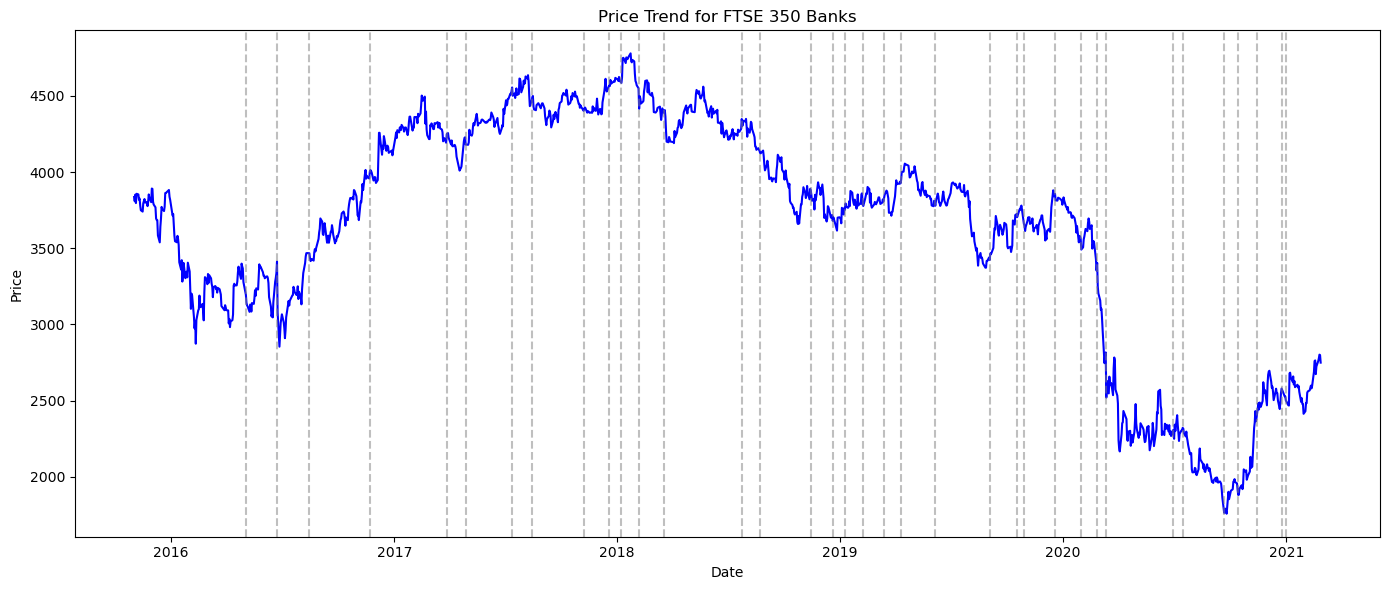

In [17]:
# Plot for FTSE 350 Banks
plt.figure(figsize=(14, 6))
plt.plot(ftse350_bank_df['Date'], ftse350_bank_df['Price'], label='FTSE 350 Banks', color='blue')
plt.title('Price Trend for FTSE 350 Banks')
plt.ylabel('Price')
plt.xlabel('Date')

# Highlight regulatory event dates for FTSE 350 Banks
for date in reg_df['Date']:
    plt.axvline(x=date, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

### Plot for FTSE 350 Insurance

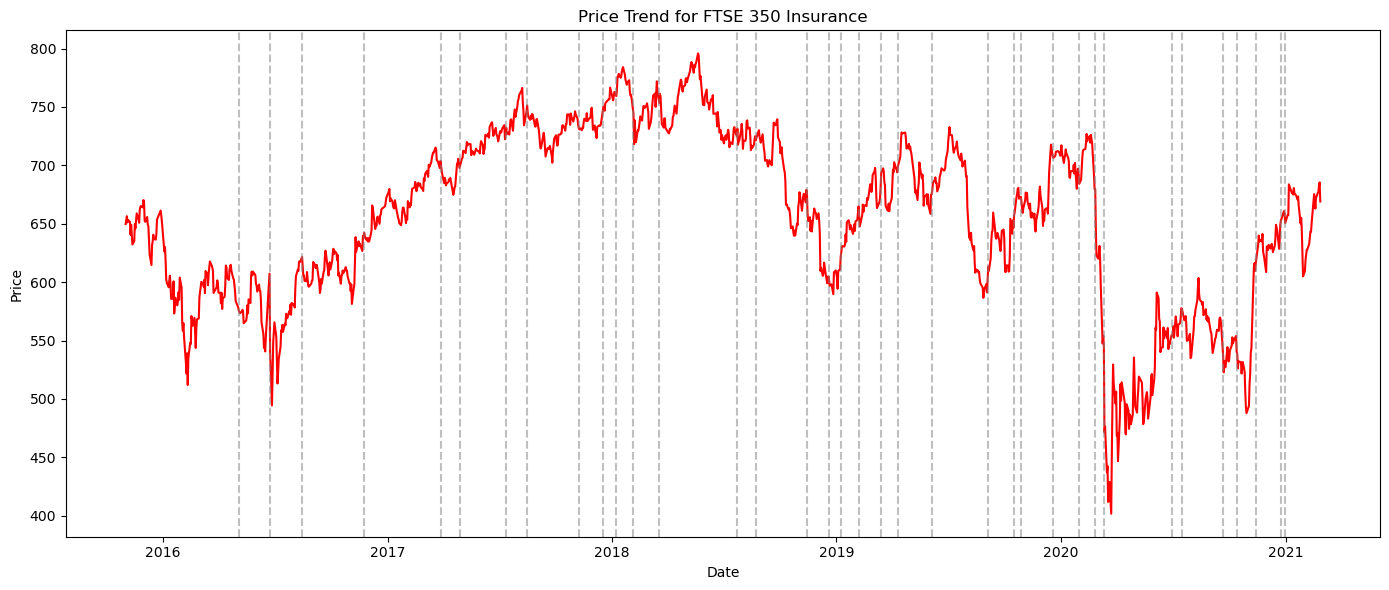

In [18]:
# Plot for FTSE 350 Insurance
plt.figure(figsize=(14, 6))
plt.plot(ftse350_insurance_df['Date'], ftse350_insurance_df['Price'], label='FTSE 350 Insurance', color='red')
plt.title('Price Trend for FTSE 350 Insurance')
plt.ylabel('Price')
plt.xlabel('Date')

# Highlight regulatory event dates for FTSE 350 Insurance
for date in reg_df['Date']:
    plt.axvline(x=date, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

### Plot for FTSE 350 Financial Services

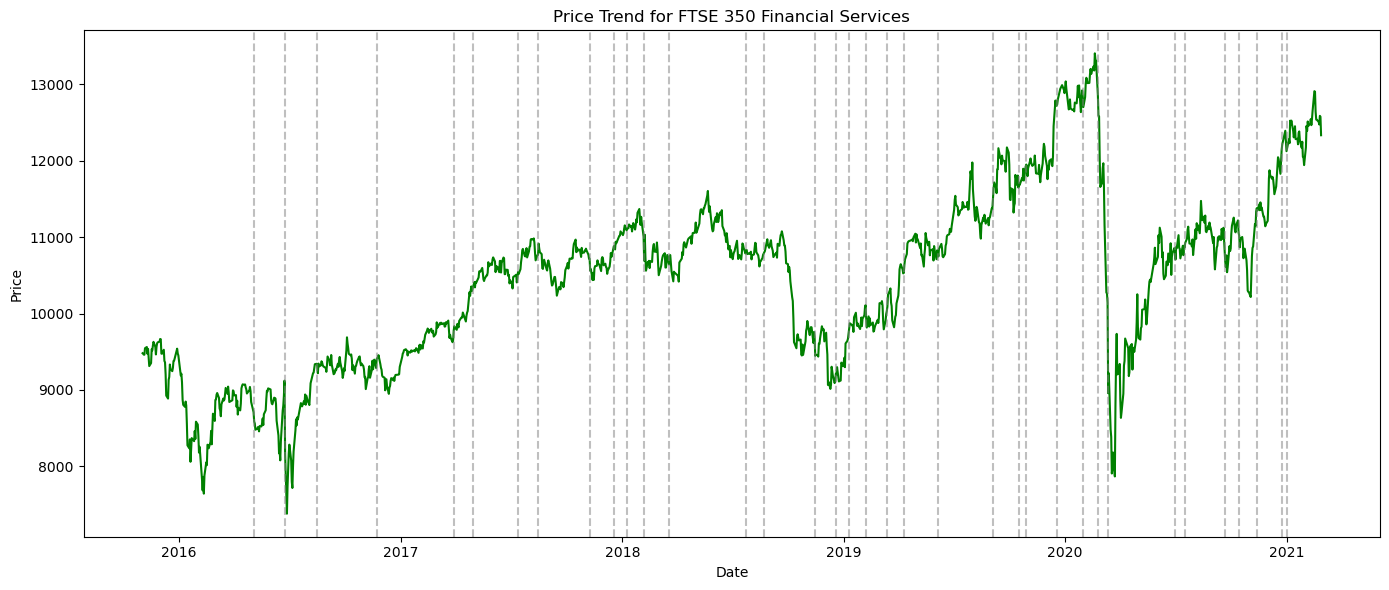

In [19]:
# Plot for FTSE 350 Financial Services
plt.figure(figsize=(14, 6))
plt.plot(ftse350_financialservices_df['Date'], ftse350_financialservices_df['Price'], label='FTSE 350 Financial Services', color='green')
plt.title('Price Trend for FTSE 350 Financial Services')
plt.ylabel('Price')
plt.xlabel('Date')

# Highlight regulatory event dates for FTSE 350 Financial Services
for date in reg_df['Date']:
    plt.axvline(x=date, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

### FTSE 350 Bank Volatility Plot

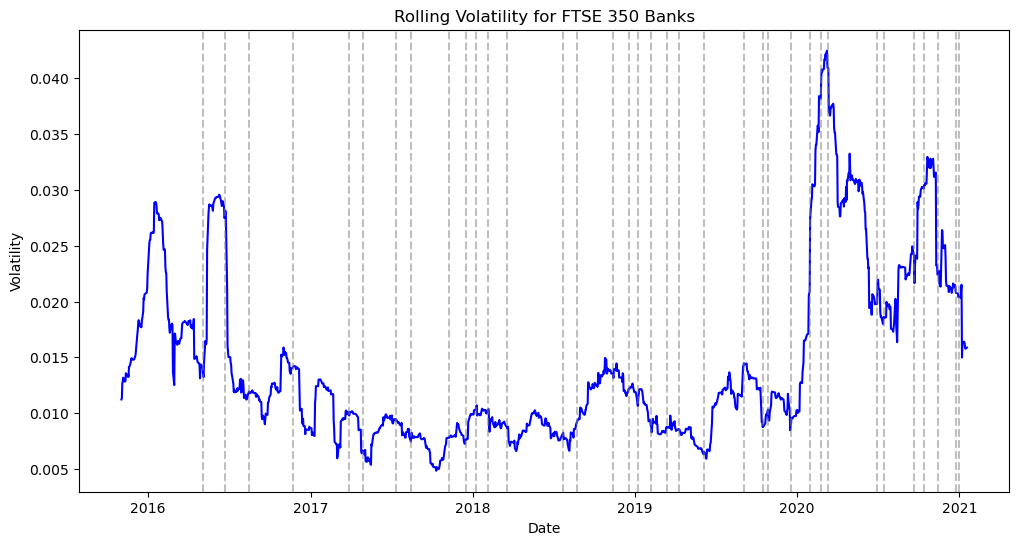

In [20]:
# FTSE 350 Banks Volatility Plot
plt.figure(figsize=(12, 6))
plt.plot(ftse350_bank_df['Date'], ftse350_bank_df['Volatility'], label='FTSE 350 Banks Volatility', color='blue')
plt.title('Rolling Volatility for FTSE 350 Banks')
plt.ylabel('Volatility')
plt.xlabel('Date')
for date in reg_df['Date']:
    plt.axvline(x=date, color='gray', linestyle='--', alpha=0.5)
plt.show()

### FTSE 350 Insurance Volatility Plot

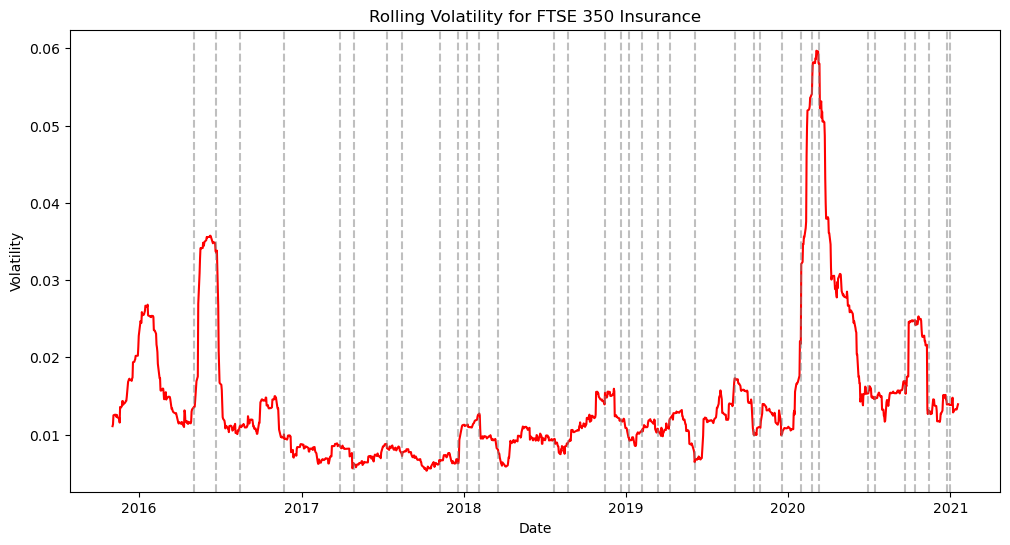

In [21]:
# FTSE 350 Insurance Volatility Plot
plt.figure(figsize=(12, 6))
plt.plot(ftse350_insurance_df['Date'], ftse350_insurance_df['Volatility'], label='FTSE 350 Insurance Volatility', color='red')
plt.title('Rolling Volatility for FTSE 350 Insurance')
plt.ylabel('Volatility')
plt.xlabel('Date')
for date in reg_df['Date']:
    plt.axvline(x=date, color='gray', linestyle='--', alpha=0.5)
plt.show()

### FTSE 350 Financial Services Volatility Plot

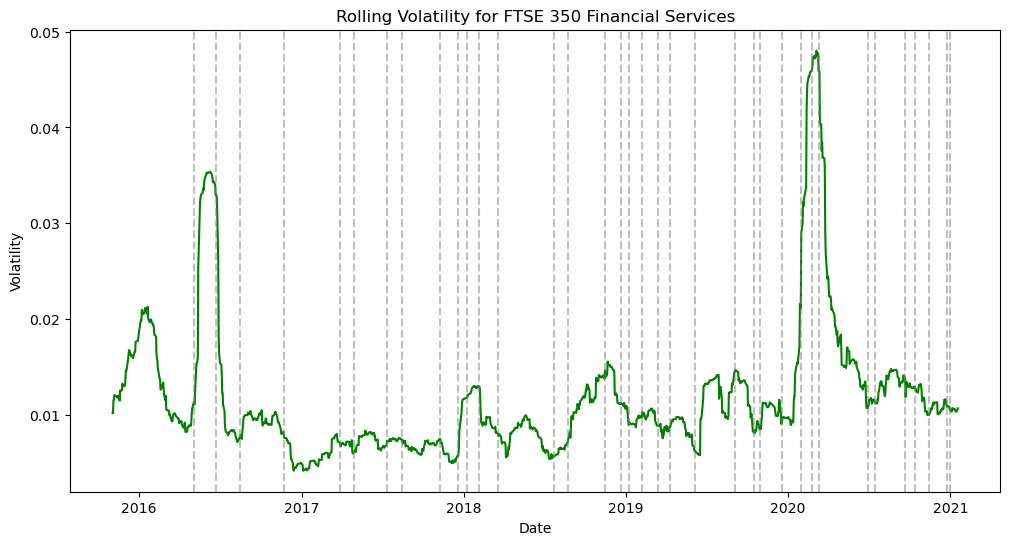

In [22]:
# FTSE 350 Financial Services Volatility Plot
plt.figure(figsize=(12, 6))
plt.plot(ftse350_financialservices_df['Date'], ftse350_financialservices_df['Volatility'], label='FTSE 350 Financial Services Volatility', color='green')
plt.title('Rolling Volatility for FTSE 350 Financial Services')
plt.ylabel('Volatility')
plt.xlabel('Date')
for date in reg_df['Date']:
    plt.axvline(x=date, color='gray', linestyle='--', alpha=0.5)
plt.show()

### Descriptive Statistics on Returns

In [23]:
# Function to extract a window of data around each regulatory announcement
def get_market_reaction(full_data, announcement_dates, window_size=20):
    # Create a list to hold the reaction data
    reaction_data = []

    # Loop through each announcement date
    for announcement in announcement_dates:
        # Get the start and end of the window around the announcement
        window_start = announcement - pd.Timedelta(days=window_size)
        window_end = announcement + pd.Timedelta(days=window_size)

        # Extract the market data within the window
        window_data = full_data.loc[window_start:window_end].copy()  # Ensure we are working with a copy

        # Add the announcement date for reference
        window_data.loc[:, 'Announcement_Date'] = announcement  # Use .loc to avoid the warning

        # Add the window data to the list
        reaction_data.append(window_data)

    # Concatenate the results into a single DataFrame
    return pd.concat(reaction_data)

# Extract the market reaction data around the announcement dates
announcement_dates = reg_df['Date']
market_reaction = get_market_reaction(full_data, announcement_dates)

# Calculate cumulative returns in the window for each sector
market_reaction['Cumulative_Returns_Banks'] = market_reaction['Banks'].cumsum()
market_reaction['Cumulative_Returns_Financial_Services'] = market_reaction['Financial_Services'].cumsum()
market_reaction['Cumulative_Returns_Insurance'] = market_reaction['Insurance'].cumsum()

# Display the summary statistics around the announcements
reaction_summary = market_reaction.groupby('Announcement_Date').agg({
    'Cumulative_Returns_Banks': ['sum', 'mean'],
    'Cumulative_Returns_Financial_Services': ['sum', 'mean'],
    'Cumulative_Returns_Insurance': ['sum', 'mean'],
    'Banks': ['std'],  # Example for volatility
    'Financial_Services': ['std'],
    'Insurance': ['std']
})

reaction_summary

Cumulative_Returns_Banks            \
                                       sum      mean   
Announcement_Date                                      
2016-05-04                         -0.1675 -0.005982   
2016-06-23                         -1.0125 -0.034914   
2016-08-15                          0.9848  0.035171   
2016-11-23                          5.4820  0.189034   
2017-03-29                          5.8541  0.216819   
2017-04-29                          4.7604  0.176311   
2017-07-13                          7.3540  0.253586   
2017-08-15                          7.0603  0.252154   
2017-11-08                          6.3629  0.219410   
2017-12-18                          6.4337  0.247450   
2018-01-08                          7.5094  0.288823   
2018-02-05                          8.1262  0.280214   
2018-03-19                          6.0546  0.224244   
2018-07-24                          6.1191  0.211003   
2018-08-23                          5.0342  0.179793   
2018-11-14                          5.3124  0.183186   
2018-12-20                          3.9357  0.151373   
2019-01-09                          4.3767  0.168335   
2019-02-07                          5.5968  0.192993   
2019-03-14                          5.7183  0.197183   
2019-04-11                          6.9428  0.257141   
2019-06-05                          7.0768  0.252743   
2019-09-04                          7.3320  0.261857   
2019-10-17                          8.5289  0.294100   
2019-10-29                         10.5814  0.364876   
2019-12-19                          9.4132  0.362046   
2020-01-31                          9.7831  0.337348   
2020-02-25                          6.7090  0.231345   
2020-03-11                         -5.6458 -0.194683   
2020-06-30                        -11.3920 -0.392828   
2020-07-16                        -12.5897 -0.434128   
2020-09-21                        -16.9014 -0.582807   
2020-10-13                        -13.3586 -0.460641   
2020-11-13                         -7.8048 -0.269131   
2020-12-24                         -4.2182 -0.162238   
2020-12-31                         -3.5607 -0.136950   

                  Cumulative_Returns_Financial_Services            \
                                                    sum      mean   
Announcement_Date                                                   
2016-05-04                                      -0.7982 -0.028507   
2016-06-23                                      -1.7375 -0.059914   
2016-08-15                                       0.1915  0.006839   
2016-11-23                                       1.2738  0.043924   
2017-03-29                                       0.4963  0.018381   
2017-04-29                                       1.7172  0.063600   
2017-07-13                                       2.5809  0.088997   
2017-08-15                                       3.2966  0.117736   
2017-11-08                                       2.4694  0.085152   
2017-12-18                                       2.9047  0.111719   
2018-01-08                                       4.1948  0.161338   
2018-02-05                                       4.8685  0.167879   
2018-03-19                                       3.7814  0.140052   
2018-07-24                                       4.2960  0.148138   
2018-08-23                                       4.2790  0.152821   
2018-11-14                                       5.1250  0.176724   
2018-12-20                                       3.1454  0.120977   
2019-01-09                                       5.5217  0.212373   
2019-02-07                                       7.2521  0.250072   
2019-03-14                                       7.9514  0.274186   
2019-04-11                                      10.0382  0.371785   
2019-06-05                                      11.7249  0.418746   
2019-09-04                                      13.6393  0.487118   
2019-10-17                             

## Statistical Testing

- Our goal for this project is to see if there some kind of Market Reaction to the Regulatory Announcements or not.

### Using T Statistical Test

- Using T Statistical Test for checking if the abnormal returns are Statistically Significant or not.

In [24]:
# Define the window for expected and event returns
pre_event_window = 10  # Days before the event to calculate expected returns
event_window = 10      # Days around the event to observe the actual impact

# Function to calculate expected and abnormal returns
def calculate_event_impact(df, event_dates, pre_event_window, event_window):
    results = []
    for event_date in event_dates:
        # Window to calculate expected returns
        window_start = pd.to_datetime(event_date) - pd.Timedelta(days=pre_event_window)
        window_end = pd.to_datetime(event_date) - pd.Timedelta(days=1)
        
        # Event window
        event_start = pd.to_datetime(event_date)
        event_end = pd.to_datetime(event_date) + pd.Timedelta(days=event_window)
        
        # Calculate mean returns in the pre-event window
        expected_returns = df[(df['Date'] >= window_start) & (df['Date'] <= window_end)]['Returns'].mean()
        
        # Calculate abnormal returns in the event window
        actual_returns = df[(df['Date'] >= event_start) & (df['Date'] <= event_end)]['Returns']
        abnormal_returns = actual_returns - expected_returns
        
        # Statistical test
        t_stat, p_value = ttest_1samp(abnormal_returns.dropna(), 0)
        
        results.append({
            'Event Date': event_date,
            'Expected Return': expected_returns,
            'Mean Abnormal Return': abnormal_returns.mean(),
            'T-Statistic': t_stat,
            'P-Value': p_value
        })
    
    return pd.DataFrame(results)

#### For FTSE 350 Banks

In [25]:
# Calculate the impact for FTSE 350 Banks
event_impact_banks = calculate_event_impact(ftse350_bank_df, reg_df['Date'], pre_event_window, event_window)

event_impact_banks

,Event Date,Expected Return,Mean Abnormal Return,T-Statistic,P-Value
0,2016-05-04,-0.007683,0.005596,1.228779,0.258857
1,2016-06-23,0.006288,-0.017045,-0.867338,0.419088
2,2016-08-15,0.009367,-0.009000,-3.635972,0.006627
3,2016-11-23,0.004429,-0.006741,-3.134240,0.016512
4,2017-03-29,-0.001243,-0.001120,-0.603767,0.565043
5,2017-04-29,0.005288,-0.002388,-0.636693,0.552328
6,2017-07-13,0.004225,-0.004954,-1.580797,0.165008
7,2017-08-15,-0.005750,0.005350,2.424316,0.041569
8,2017-11-08,-0.003043,0.002680,2.463395,0.043250
9,2017-12-18,0.005550,-0.003493,-1.901357,0.105970


#### For FTSE 350 Financial Services

In [26]:
# Calculate the impact for FTSE 350 Financial Services
event_impact_financial_services = calculate_event_impact(ftse350_financialservices_df, reg_df['Date'], pre_event_window, event_window)

event_impact_financial_services

,Event Date,Expected Return,Mean Abnormal Return,T-Statistic,P-Value
0,2016-05-04,-4.566667e-03,0.001967,0.795791,0.452291
1,2016-06-23,4.975000e-03,-0.013718,-0.571035,0.588709
2,2016-08-15,7.300000e-03,-0.007422,-3.286993,0.011072
3,2016-11-23,3.828571e-03,-0.006916,-3.702005,0.007635
4,2017-03-29,-3.185714e-03,0.006473,2.830303,0.025395
5,2017-04-29,4.987500e-03,-0.002138,-0.836949,0.440776
6,2017-07-13,4.250000e-04,0.004661,2.935578,0.026097
7,2017-08-15,-3.200000e-03,0.002600,0.904671,0.392069
8,2017-11-08,-9.714286e-04,-0.000154,-0.041544,0.968022
9,2017-12-18,3.933333e-03,-0.000648,-0.287140,0.783663


#### For FTSE 350 Insurance

In [27]:
# Calculate the impact for FTSE 350 Insurance
event_impact_insurance = calculate_event_impact(ftse350_insurance_df, reg_df['Date'], pre_event_window, event_window)

event_impact_insurance

,Event Date,Expected Return,Mean Abnormal Return,T-Statistic,P-Value
0,2016-05-04,-0.008733,0.005896,2.659405,0.032495
1,2016-06-23,0.007262,-0.013377,-0.542521,0.607007
2,2016-08-15,0.006250,-0.010017,-3.254216,0.011627
3,2016-11-23,0.003129,-0.004079,-2.307452,0.054391
4,2017-03-29,-0.001386,-0.002102,-1.087044,0.313025
5,2017-04-29,0.004250,-0.000133,-0.059615,0.954772
6,2017-07-13,0.001062,0.001466,0.624791,0.555108
7,2017-08-15,-0.003883,0.003961,2.178067,0.061046
8,2017-11-08,-0.001443,0.002405,1.899919,0.099218
9,2017-12-18,0.003567,-0.000138,-0.055864,0.957264


### GARCH, EGARCH, GJR-GARCH Model

DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002665. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.
    
This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

It’s generally beneficial to rescale returns for volatility modeling due to improved numerical
stability, ease of interpretation, and potentially better performance of the optimization
algorithms used in parameter estimation. The essential relationships and dynamics captured by 
the model are not altered by rescaling, so this practice does not fundamentally change 
the model’s insights about volatility.

In [28]:
# Define the event window
window_size = 10

# Create a copy of the original 'Regulatory_Announcements' to adjust it
announcements_window = np.zeros(len(full_data))  # Initialize with 0s
announcement_dates = data.index[full_data['Regulatory_Announcements'] == 1].tolist()  # Get announcement dates

# Set the window for each announcement
for announcement_date in announcement_dates:
    start = max(0, announcement_date - window_size)
    end = min(len(full_data) - 1, announcement_date + window_size)
    announcements_window[start:end + 1] = 1  # Set 1 within the window

# Add the new window-based announcement variable to the DataFrame
full_data['Regulatory_Announcements_Window'] = announcements_window

In [29]:
# Define the function to fit GARCH, EGARCH, and GJR-GARCH models with the windowed regulatory announcements
def fit_garch_model_with_window(returns, announcements_window):
    results = {}
    specs = {
        'GARCH': ('Garch', 0),
        'EGARCH': ('EGarch', 0),
        'GJR-GARCH': ('Garch', 1)  # Note the use of 'Garch' with o=1 for GJR-GARCH
    }

    for model_name, (vol_model, order_o) in specs.items():
        model = arch_model(returns * 100, mean='Zero', vol=vol_model, p=1, o=order_o, q=1, dist='normal', x=announcements_window)
        fitted_model = model.fit(disp='off')
        results[model_name] = fitted_model
    
    return results

#### FTSE 350 Bank Data

In [30]:
returns = ftse350_bank_df.Returns.dropna()

# Fit the models to your returns data
models_results = fit_garch_model_with_window(returns, announcements_window)

# Display the summary of each model's results
for model_name, result in models_results.items():
    print(f"Results for {model_name}:")
    print(result.summary())
    print("\n")

Results for GARCH:
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -2321.30
Distribution:                  Normal   AIC:                           4648.59
Method:            Maximum Likelihood   BIC:                           4664.21
                                        No. Observations:                 1347
Date:                Mon, Sep 23 2024   Df Residuals:                     1347
Time:                        19:53:32   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0173  1.336e-02    

#### FTSE 350 Insurance Data

In [31]:
returns = ftse350_insurance_df.Returns.dropna()

# Fit the models to your returns data
models_results = fit_garch_model_with_window(returns, announcements_window)

# Display the summary of each model's results
for model_name, result in models_results.items():
    print(f"Results for {model_name}:")
    print(result.summary())
    print("\n")

Results for GARCH:
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -2264.04
Distribution:                  Normal   AIC:                           4534.07
Method:            Maximum Likelihood   BIC:                           4549.69
                                        No. Observations:                 1347
Date:                Mon, Sep 23 2024   Df Residuals:                     1347
Time:                        19:53:32   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.0700  3.355e-02      2.085  

#### FTSE 350 Financial Services Data

In [32]:
returns = ftse350_financialservices_df.Returns.dropna()

# Fit the models to your returns data
models_results = fit_garch_model_with_window(returns, announcements_window)

# Display the summary of each model's results
for model_name, result in models_results.items():
    print(f"Results for {model_name}:")
    print(result.summary())
    print("\n")

Results for GARCH:
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -2019.45
Distribution:                  Normal   AIC:                           4044.90
Method:            Maximum Likelihood   BIC:                           4060.51
                                        No. Observations:                 1347
Date:                Mon, Sep 23 2024   Df Residuals:                     1347
Time:                        19:53:33   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.0813  3.336e-02      2.437  

### Granger causality test

In [33]:
# Function to run Granger causality tests
def run_granger_tests(data, dependent_vars, maxlags=12):
    results = {}
    for var in dependent_vars:
        print(f"\nTesting Granger Causality for {var} caused by Regulatory Announcements:")
        # Run the Granger causality test
        test_result = grangercausalitytests(data[[var, 'Regulatory_Announcements']], maxlag=maxlags)
        # Collect the p-values from the tests at each lag
        p_values = {lag: round(result[0]['ssr_chi2test'][1], 4) for lag, result in test_result.items()}
        results[var] = p_values
        # Print minimum p-value across lags
        min_p_val = min(p_values.values())
        print(f"Minimum P-value for {var}: {min_p_val} at lag {min(p_values, key=p_values.get)}")
    return results

# The 'full_data' includes columns for 'Banks', 'Financial_Services', and 'Insurance'
granger_results = run_granger_tests(full_data, ['Banks', 'Financial_Services', 'Insurance'])


Testing Granger Causality for Banks caused by Regulatory Announcements:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.6295  , p=0.0058  , df_denom=1343, df_num=1
ssr based chi2 test:   chi2=7.6466  , p=0.0057  , df=1
likelihood ratio test: chi2=7.6249  , p=0.0058  , df=1
parameter F test:         F=7.6295  , p=0.0058  , df_denom=1343, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.8337  , p=0.0219  , df_denom=1340, df_num=2
ssr based chi2 test:   chi2=7.6961  , p=0.0213  , df=2
likelihood ratio test: chi2=7.6741  , p=0.0216  , df=2
parameter F test:         F=3.8337  , p=0.0219  , df_denom=1340, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.7969  , p=0.0390  , df_denom=1337, df_num=3
ssr based chi2 test:   chi2=8.4345  , p=0.0378  , df=3
likelihood ratio test: chi2=8.4082  , p=0.0383  , df=3
parameter F test:         F=2.7969  , p=0.0390  , df_denom=1337, df_num=3

Granger Causal

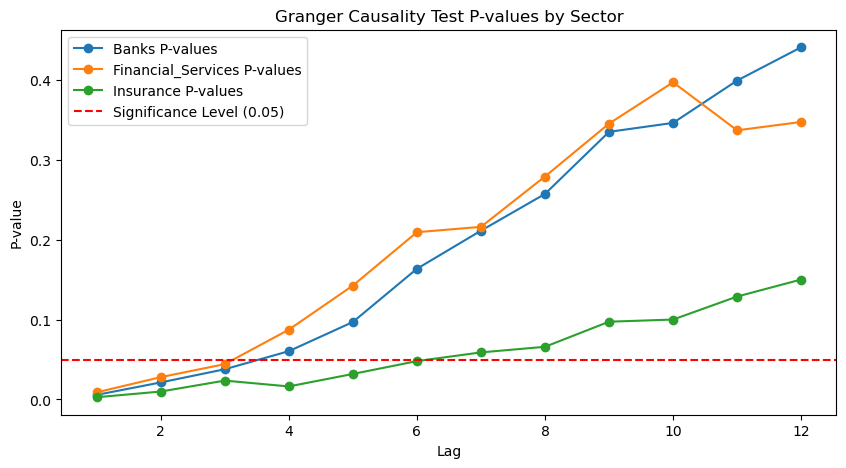

In [34]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 5))
for sector, values in granger_results.items():
    lags = list(values.keys())
    p_values = list(values.values())
    ax.plot(lags, p_values, marker='o', label=f'{sector} P-values')

ax.axhline(0.05, color='red', linestyle='--', label='Significance Level (0.05)')
ax.set_xlabel('Lag')
ax.set_ylabel('P-value')
ax.set_title('Granger Causality Test P-values by Sector')
ax.legend()
plt.show()

### OLS Regression Test

In [35]:
# Define the independent variables matrix (add a constant to the model)
X = sm.add_constant(full_data['Regulatory_Announcements'])  # Adds a constant term to the predictor

# 'Banks' sector
y = full_data['Banks'] * 100  

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Print the summary of the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Banks   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.094
Date:                Mon, 23 Sep 2024   Prob (F-statistic):              0.296
Time:                        19:53:34   Log-Likelihood:                -2571.0
No. Observations:                1347   AIC:                             5146.
Df Residuals:                    1345   BIC:                             5156.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [36]:
# 'Insurance' sector
y = full_data['Insurance'] * 100  

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Print the summary of the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              Insurance   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.7388
Date:                Mon, 23 Sep 2024   Prob (F-statistic):              0.390
Time:                        19:53:34   Log-Likelihood:                -2588.2
No. Observations:                1347   AIC:                             5180.
Df Residuals:                    1345   BIC:                             5191.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [37]:
# 'Financial_Services' sector
y = full_data['Financial_Services'] * 100  

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Print the summary of the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     Financial_Services   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.324
Date:                Mon, 23 Sep 2024   Prob (F-statistic):              0.250
Time:                        19:53:34   Log-Likelihood:                -2334.2
No. Observations:                1347   AIC:                             4672.
Df Residuals:                    1345   BIC:                             4683.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

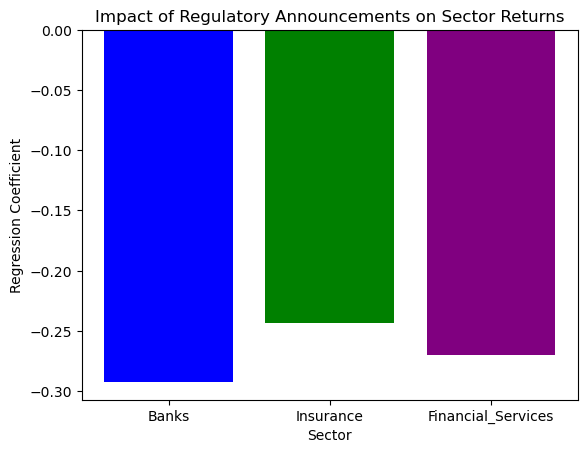

In [38]:
coefficients = {
    'Banks': -0.2925,
    'Insurance': -0.2435,
    'Financial_Services': -0.2700
}

fig, ax = plt.subplots()
sectors = list(coefficients.keys())
values = list(coefficients.values())

ax.bar(sectors, values, color=['blue', 'green', 'purple'])
ax.set_xlabel('Sector')
ax.set_ylabel('Regression Coefficient')
ax.set_title('Impact of Regulatory Announcements on Sector Returns')
plt.show()

### VAR (Vector Auto-Regression) Model

#### Checking if the Data is Stationary or Not. As VAR requires the Data to be Stationary

In [39]:
# Function to check stationarity with Augmented Dickey-Fuller test
def check_stationarity(series, signif=0.05, name='', verbose=False):
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic': round(r[0], 4), 'pvalue': round(r[1], 4), 'critical_values': r[4]}
    if verbose:
        print(f'Augmented Dickey-Fuller Test on "{name}"', '\n', '-'*47)
        print(f'Null Hypothesis: Data has unit root. Non-Stationary.')
        print(f'Significance Level    = {signif}')
        print(f'Test Statistic        = {output["test_statistic"]}')
        print(f'No. Lags Chosen       = {r[2]}')
        for key, value in r[4].items():
            print(f'Critical value {key} = {round(value, 3)}')
    
    if output['pvalue'] <= signif:
        print(f" => P-Value = {output['pvalue']}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {output['pvalue']}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")
    return output

# Example usage of stationarity check
for col in data.columns:
    if col == 'Date':
        continue
    print('===========' * 6, '\n')
    check_stationarity(data[col], name=col, verbose=True)
    print('\n'+'===========' * 6, '\n')


Augmented Dickey-Fuller Test on "Banks" 
 -----------------------------------------------
Null Hypothesis: Data has unit root. Non-Stationary.
Significance Level    = 0.05
Test Statistic        = -13.5416
No. Lags Chosen       = 7
Critical value 1% = -3.435
Critical value 5% = -2.864
Critical value 10% = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.



Augmented Dickey-Fuller Test on "Financial_Services" 
 -----------------------------------------------
Null Hypothesis: Data has unit root. Non-Stationary.
Significance Level    = 0.05
Test Statistic        = -13.172
No. Lags Chosen       = 7
Critical value 1% = -3.435
Critical value 5% = -2.864
Critical value 10% = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.



Augmented Dickey-Fuller Test on "Insurance" 
 -----------------------------------------------
Null Hypothesis: Data has unit root. Non-Stationary.
Significance Level    = 0.05
Test Statistic        = -13.4102
No

#### As the Data is Stationary we can proceed.

#### FTSE 350 Bank Data

In [40]:
# Create a temporary copy of the data for the VAR model
temp_data = full_data[['Banks', 'Regulatory_Announcements']].copy()

# Multiply the 'Banks' column by 100
temp_data['Banks'] = temp_data['Banks'] * 100

# Fit the VAR model with the transformed 'Banks' column and 'Regulatory_Announcements'
model = VAR(temp_data)
var_results = model.fit(maxlags=20, ic='aic')

# Print the model summary
print(var_results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 23, Sep, 2024
Time:                     19:53:37
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -2.67015
Nobs:                     1346.00    HQIC:                  -2.68467
Log likelihood:          -2001.15    FPE:                  0.0676536
AIC:                     -2.69336    Det(Omega_mle):       0.0673530
--------------------------------------------------------------------
Results for equation Banks
                                 coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------------
const                               0.008744         0.045026            0.194           0.846
L1.Banks                            0.001059         0.027233            0.039           0.969
L1.R

/Users/bhanuprasanna/anaconda3/envs/DAI_MR_RAA/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


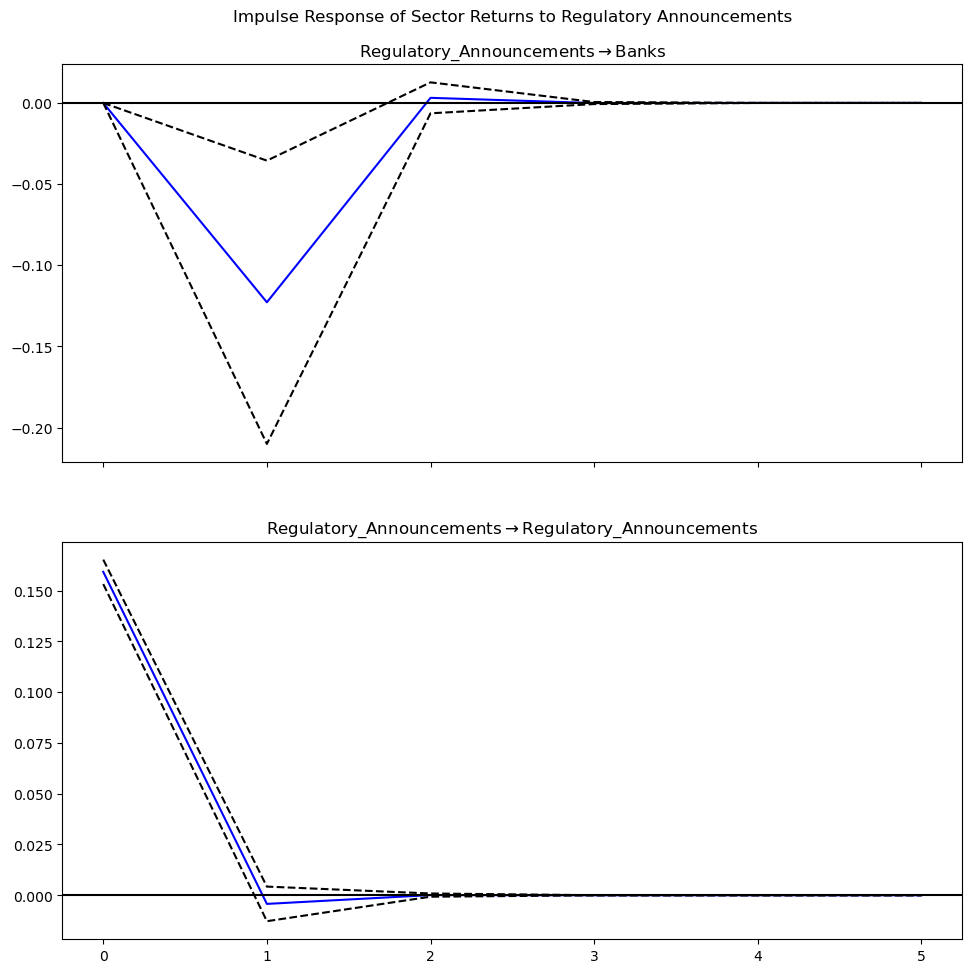

In [41]:
# Generate Impulse Response Functions for 10 periods
irf = var_results.irf(5)

# Plot the IRFs specifically for shocks to Regulatory Announcements
irf_plot = irf.plot(impulse='Regulatory_Announcements', orth=True)
irf_plot.suptitle('Impulse Response of Sector Returns to Regulatory Announcements')
plt.show()

#### FTSE 350 Insurance Data

In [42]:
# Create a temporary copy of the data for the VAR model
temp_data_insurance = full_data[['Insurance', 'Regulatory_Announcements']].copy()

# Multiply the 'Insurance' column by 100
temp_data_insurance['Insurance'] = temp_data_insurance['Insurance'] * 100

# Fit the VAR model with the transformed 'Insurance' column and 'Regulatory_Announcements'
model = VAR(temp_data_insurance)
var_results = model.fit(maxlags=20, ic='aic')

# Print the model summary
print(var_results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 23, Sep, 2024
Time:                     19:53:39
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -2.53502
Nobs:                     1339.00    HQIC:                  -2.61759
Log likelihood:          -1980.33    FPE:                  0.0694569
AIC:                     -2.66705    Det(Omega_mle):       0.0677263
--------------------------------------------------------------------
Results for equation Insurance
                                 coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------------
const                               0.048024         0.049889            0.963           0.336
L1.Insurance                        0.090841         0.027435            3.311           0.001


/Users/bhanuprasanna/anaconda3/envs/DAI_MR_RAA/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


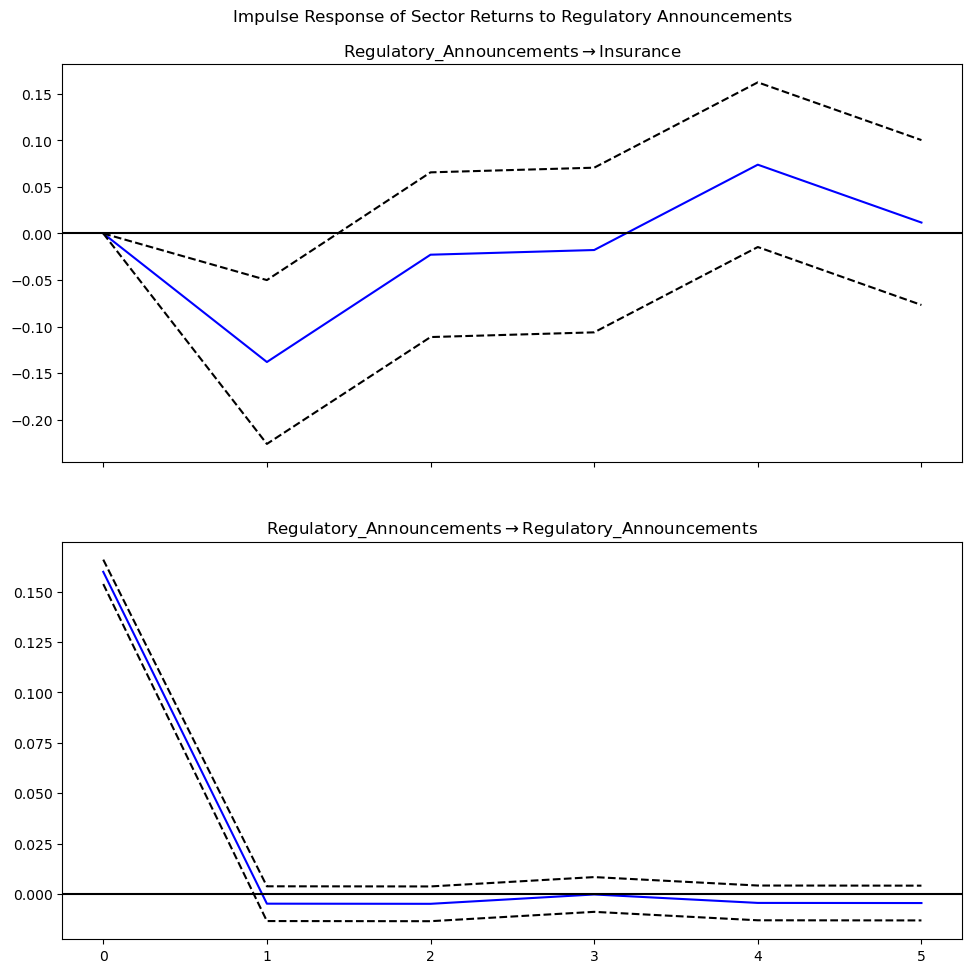

In [43]:
# Generate Impulse Response Functions for 10 periods
irf = var_results.irf(5)

# Plot the IRFs specifically for shocks to Regulatory Announcements
irf_plot = irf.plot(impulse='Regulatory_Announcements', orth=True)
irf_plot.suptitle('Impulse Response of Sector Returns to Regulatory Announcements')
plt.show()

#### FTSE 350 Financial Services Data

In [44]:
# Create a temporary copy of the data for the VAR model
temp_data_fs = full_data[['Financial_Services', 'Regulatory_Announcements']].copy()

# Multiply the 'Financial_Services' column by 100
temp_data_fs['Financial_Services'] = temp_data_fs['Financial_Services'] * 100

# Fit the VAR model with the transformed 'Financial_Services' column and 'Regulatory_Announcements'
model = VAR(temp_data_fs)
var_results = model.fit(maxlags=20, ic='aic')

# Print the model summary
print(var_results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 23, Sep, 2024
Time:                     19:53:41
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -3.02477
Nobs:                     1346.00    HQIC:                  -3.03928
Log likelihood:          -1762.50    FPE:                  0.0474550
AIC:                     -3.04797    Det(Omega_mle):       0.0472441
--------------------------------------------------------------------
Results for equation Financial_Services
                                 coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------------
const                               0.043368         0.037739            1.149           0.250
L1.Financial_Services               0.054036         0.027209            1.986        

/Users/bhanuprasanna/anaconda3/envs/DAI_MR_RAA/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


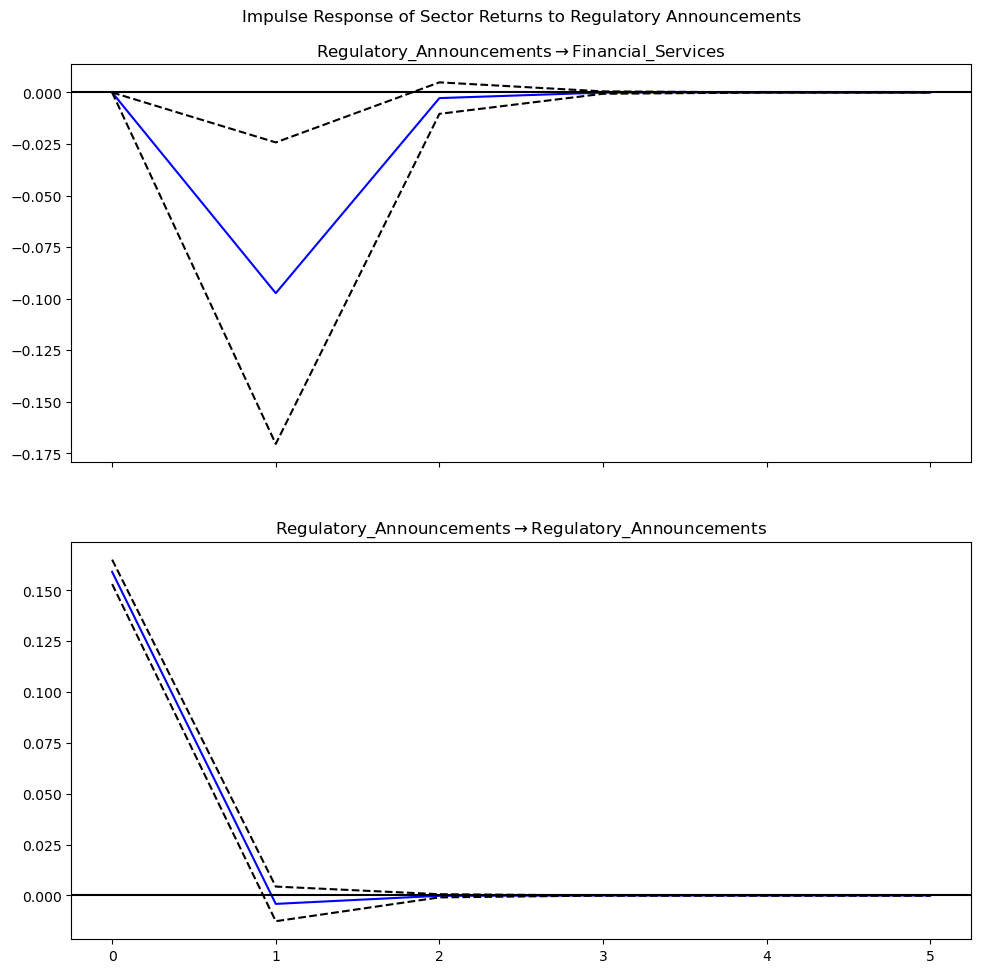

In [45]:
# Generate Impulse Response Functions for 10 periods
irf = var_results.irf(5)

# Plot the IRFs specifically for shocks to Regulatory Announcements
irf_plot = irf.plot(impulse='Regulatory_Announcements', orth=True)
irf_plot.suptitle('Impulse Response of Sector Returns to Regulatory Announcements')
plt.show()